In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from torchvision import transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler

from umap import UMAP
from sklearn.cluster import DBSCAN
import time
from tensorflow.keras.losses import CategoricalCrossentropy
import pickle
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

/mnt/c/Users/sejrs/Documents/Code/AppMLFinalProject


# Add labels to meta data

In [10]:
labels_raw = [np.load('./labels/'+x) for x in os.listdir('./labels/') if x.endswith('.npy')]

label_dict = {}
value_array = []
for values in labels_raw:
    for value,ind in zip(values[0],values[1]):
        value_array.append(value)
        #print(value)
        label_dict[value] = ind

meta_data = pd.read_csv('cluster_meta.csv')
file_index = meta_data['cluster'].values

label_list = [label_dict[int(x[:-2])] for x in file_index]

meta_data.insert(6,'label',label_list)

meta_data = meta_data.drop(meta_data[meta_data['label'] == 4].index)
meta_data = meta_data.drop(meta_data[meta_data['label'] == 0].index)
meta_data['label'] = meta_data['label'] - 1



meta_data = meta_data.to_csv('cluster_meta_labels.csv', index = False)

# Import Data

In [11]:


meta_data = pd.read_csv('cluster_meta_labels.csv')
print(meta_data.head())

def load_data_with_label(folder_path, meta_data):
    data = []
    for file in meta_data['cluster']:
        file = file + '.csv'
        file_path = os.path.join(folder_path,file)
        cluster = pd.read_csv(file_path,header=None).values
        cluster = cluster.flatten()
        # cluster = np.append(cluster, meta_data[meta_data['cluster'] == file[:-4]][['y', 'x', 'E', 'size']].values.flatten())
        data.append(cluster)
    combined_array = np.stack(data,axis=0)
    print('shape of combined array: ')
    print(combined_array.shape)
    return combined_array, meta_data[['y', 'x', 'E', 'size']].values, meta_data['label'].values




meta_scaler = RobustScaler()
meta_data_values = meta_scaler.fit_transform(meta_data[['y', 'x', 'E', 'size']])



   Unnamed: 0   cluster     y     x          E   size  label
0           0  004580_A   9.0  26.0   715232.0  108.0      2
1           2  003882_A   3.0   3.0    31156.0    6.0      0
2           3  009717_G   7.0  62.0  1423016.0  245.0      2
3           4  005590_A  32.0  31.0  1014772.0  169.0      2
4           5  008859_G  13.0   9.0   397825.0   63.0      2


In [12]:
class NumpyArrayDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample  # Return only the sample and dummy label





folder_path = 'clusters_colour_rotations_rescaled'
combined_array, meta_data_values, meta_data_labels = load_data_with_label(folder_path, meta_data)

meta_data_labels = meta_data_labels.astype(int)







shape of combined array: 
(3112, 4096)


# Normelize Data

In [13]:
scaler = MinMaxScaler()
combined_array_scaled = scaler.fit_transform(np.log(combined_array))
print(combined_array.shape)

meta_scaler = QuantileTransformer()
meta_data_values = meta_scaler.fit_transform(meta_data_values)

combined_array_scaled = np.append(combined_array_scaled, meta_data_values, axis=1)

combined_array_scaled = np.append(combined_array_scaled, meta_data_labels[:,None], axis=1)
#print(combined_array_scaled.T[-5:])

transform = transforms.Compose([
    transforms.ToTensor()
])

np.random.shuffle(combined_array_scaled)

#meta_data_values = NumpyArrayDataset(meta_data_values, transform=transform)
dataset = NumpyArrayDataset(combined_array_scaled, transform=transform)
print(combined_array_scaled.shape)

# lazy, non-random split
test_size = 0.2
split_index = int(len(dataset) * (1 - test_size))
train_dataset = dataset[:split_index]
test_dataset = dataset[split_index:]
#train_meta = meta_data_values[:split_index]
#test_meta = meta_data_values[split_index:]
#train_labels = meta_data_labels[:split_index]
#test_labels = meta_data_labels[split_index:]


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(train_loader.dataset[0].shape)






(3112, 4096)
(3112, 4101)
torch.Size([2489, 4101])


# Chosse device

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda', index=0)

# Create Model

In [30]:



def create_torch_model_CNN_HPO(trial):
    N_conv_layers = trial.suggest_int('N_conv_layers', 1, 3)
    N_dense_layers = trial.suggest_int('N_dense_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    num_classes = 3
    class torch_CNN_HPO(nn.Module):
        def __init__(self):
            super().__init__()


            ### Flattening:
            self.flatten = nn.Flatten(start_dim=0)

            self.peram_to_optimize = []
            ### dropout
            self.dropout = nn.Dropout(dropout_rate, inplace=True)

            self.compile_model()
        
        def create_CNN_layer(self, size_in, filters_in, layer_number):
            filters_out = trial.suggest_int('filters_layer'+str(layer_number), 8, 64)
            filter_size = trial.suggest_int('filter_size_layer'+str(layer_number), 3, 7)
            stride_cnn = trial.suggest_int('stride_layer'+str(layer_number), 1, 3)
            padding = trial.suggest_int('padding_layer'+str(layer_number), 1, 3)
            pool_size = 3
            pool_stride = 1
            pool_padding = 1
            cnn_layer = nn.Sequential(
                nn.Conv2d(filters_in, filters_out, filter_size, stride=stride_cnn, padding=padding),  # 1x256x256 -> 32x128x128
                nn.ReLU(True),
                nn.MaxPool2d(pool_size, stride=pool_stride, padding=pool_padding)  # 64x64x64 -> 64x32x32
            ).to(device)
            size_out = (size_in - filter_size + 2*padding) // stride_cnn + 1
            return cnn_layer, filters_out, size_out
        
        def create_liniar_layer(self, input_size, layer_number):
            output_size = trial.suggest_int('dense_layer'+str(layer_number), 8, 128)
            liniar_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU(True)
            ).to(device)
            return liniar_layer, output_size
        
        def create_output_layer(self, input_size, output_size):
            output_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU()
            ).to(device)
            return output_layer
        
        def compile_model(self):
            #print('Model compiled')
            model_layers_cnn = []
            model_layers_dense = []
            size_in = 64
            for i in range(N_conv_layers):
                if i == 0:
                    cnn_layer, filters_out, size_out = self.create_CNN_layer(size_in, 1, i)
                else:
                    cnn_layer, filters_out, size_out = self.create_CNN_layer(size_out, filters_out, i)
                self.peram_to_optimize.append({'params': cnn_layer.parameters()})
                model_layers_cnn.append(cnn_layer)

            output_size = size_out ** 2 * filters_out
            for i in range(N_dense_layers):
                if i == 0:
                    liniar_layer, output_size = self.create_liniar_layer(output_size, i)
                else:
                    liniar_layer, output_size = self.create_liniar_layer(output_size, i)
                self.peram_to_optimize.append({'params': liniar_layer.parameters()})
                model_layers_dense.append(liniar_layer)
            
            output_layer = self.create_output_layer(output_size + 4, num_classes)
            self.peram_to_optimize.append({'params': output_layer.parameters()})
        
    
            
            def model_compiled_v2(x, meta):
                for layer in model_layers_cnn:
                    x = layer(x)
                #print(x.shape)
                x = self.flatten(x)
                x = self.dropout(x)
                for layer in model_layers_dense:
                    x = layer(x)
                y = torch.cat((x, meta), dim=0)
                x = output_layer(y)
                return x
            self.model_compiled = model_compiled_v2


        def forward(self, x):
            
            meta = x[-5:-1]
            label = x[-1]
            x = x[:-5].unflatten(0, (1, 1, 64, 64))

            x = self.model_compiled(x, meta)
            #print(label.type(), x.type())
            return x, label#.type(torch.cuda.ByteTensor)
    return torch_CNN_HPO().to(device)


def create_torch_model_CNN_dict(trial):
    N_conv_layers = trial['N_conv_layers']
    N_dense_layers = trial['N_dense_layers']
    dropout_rate = trial['dropout_rate']
    num_classes = 3
    class torch_CNN_HPO(nn.Module):
        def __init__(self):
            super().__init__()


            ### Flattening:
            self.flatten = nn.Flatten(start_dim=0)

            self.peram_to_optimize = []
            ### dropout
            self.dropout = nn.Dropout(dropout_rate, inplace=True)

            self.compile_model()
        
        def create_CNN_layer(self, size_in, filters_in, layer_number):
            filters_out = trial['filters_layer'+str(layer_number)]
            filter_size = trial['filter_size_layer'+str(layer_number)]
            stride_cnn = trial['stride_layer'+str(layer_number)]
            padding = trial['padding_layer'+str(layer_number)]
            pool_size = 3
            pool_stride = 1
            pool_padding = 1
            cnn_layer = nn.Sequential(
                nn.Conv2d(filters_in, filters_out, filter_size, stride=stride_cnn, padding=padding),  # 1x256x256 -> 32x128x128
                nn.ReLU(True),
                nn.MaxPool2d(pool_size, stride=pool_stride, padding=pool_padding)  # 64x64x64 -> 64x32x32
            ).to(device)
            size_out = (size_in - filter_size + 2*padding) // stride_cnn + 1
            return cnn_layer, filters_out, size_out
        
        def create_liniar_layer(self, input_size, layer_number):
            output_size = trial['dense_layer'+str(layer_number)]
            liniar_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU(True)
            ).to(device)
            return liniar_layer, output_size
        
        def create_output_layer(self, input_size, output_size):
            output_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU()
            ).to(device)
            return output_layer
        
        def compile_model(self):
            #print('Model compiled')
            model_layers_cnn = []
            model_layers_dense = []
            size_in = 64
            for i in range(N_conv_layers):
                if i == 0:
                    cnn_layer, filters_out, size_out = self.create_CNN_layer(size_in, 1, i)
                else:
                    cnn_layer, filters_out, size_out = self.create_CNN_layer(size_out, filters_out, i)
                self.peram_to_optimize.append({'params': cnn_layer.parameters()})
                model_layers_cnn.append(cnn_layer)

            output_size = size_out ** 2 * filters_out
            for i in range(N_dense_layers):
                if i == 0:
                    liniar_layer, output_size = self.create_liniar_layer(output_size, i)
                else:
                    liniar_layer, output_size = self.create_liniar_layer(output_size, i)
                self.peram_to_optimize.append({'params': liniar_layer.parameters()})
                model_layers_dense.append(liniar_layer)
            
            output_layer = self.create_output_layer(output_size + 4, num_classes)
            self.peram_to_optimize.append({'params': output_layer.parameters()})
        
    
            
            def model_compiled_v2(self, x, meta):
                for layer in model_layers_cnn:
                    x = layer(x)
                #print(x.shape)
                x = self.flatten(x)
                x = self.dropout(x)
                for layer in model_layers_dense:
                    x = layer(x)
                y = torch.cat((x, meta), dim=0)
                x = output_layer(y)
                return x
            self.model_compiled = self.model_compiled_v2


        def forward(self, x):
            
            meta = x[-5:-1]
            label = x[-1]
            x = x[:-5].unflatten(0, (1, 1, 64, 64))

            x = self.model_compiled(x, meta)
            #print(label.type(), x.type())
            return x, label#.type(torch.cuda.ByteTensor)
    return torch_CNN_HPO().to(device)



def create_torch_model_CNN():
    N_conv_layers = 1
    N_dense_layers = 1
    dropout_rate = 0.4
    num_classes = 3
    
    

    class torch_CNN(nn.Module):
        def __init__(self):
            super().__init__()


            ### Flattening:
            self.flatten = nn.Flatten(start_dim=0)
            self.peram_to_optimize = []

            ### dropout
            self.dropout = nn.Dropout(dropout_rate, inplace=True)

            self.compile_model()

        
        def create_CNN_layer(self, size_in, filters_in):
            filters_out = 8
            filter_size = 3
            stride_cnn = 1
            padding = 1
            pool_size = 3
            pool_stride = 1
            pool_padding = 1
            cnn_layer = nn.Sequential(
                nn.Conv2d(filters_in, filters_out, filter_size, stride=stride_cnn, padding=padding),  # 1x256x256 -> 32x128x128
                nn.ReLU(True),
                nn.MaxPool2d(pool_size, stride=pool_stride, padding=pool_padding)  # 64x64x64 -> 64x32x32
            ).to(device)
            size_out = (size_in - filter_size + 2*padding) // stride_cnn + 1
            return cnn_layer, filters_out, size_out
        
        def create_liniar_layer(self, input_size):
            output_size = 32
            liniar_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU(True)
            ).to(device)
            return liniar_layer, output_size
        
        def create_output_layer(self, input_size, output_size):
            output_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU()
            ).to(device)
            return output_layer
        
        
        
        def compile_model(self):
            model_layers_cnn = []
            model_layers_dense = []
            size_in = 32
            for i in range(N_conv_layers):
                if i == 0:
                    cnn_layer, filters_out, size_out = self.create_CNN_layer(size_in, 1)
                else:
                    cnn_layer, filters_out, size_out = self.create_CNN_layer(size_out, filters_out)

                self.peram_to_optimize.append({'params': cnn_layer.parameters()})
                model_layers_cnn.append(cnn_layer)

            #output_size = size_out ** 2 * filters_out
            output_size = filters_out
            for i in range(N_dense_layers):
                if i == 0:
                    liniar_layer, output_size = self.create_liniar_layer(output_size)
                else:
                    liniar_layer, output_size = self.create_liniar_layer(output_size)
                self.peram_to_optimize.append({'params': liniar_layer.parameters()})
                model_layers_dense.append(liniar_layer)
            
            output_layer = self.create_output_layer(output_size + 4, num_classes)
            self.peram_to_optimize.append({'params': output_layer.parameters()})
            
            
            def model_compiled_v2(x, meta):
                for layer in model_layers_cnn:
                    x = layer(x)
                   
                #print(x.shape)
                x = torch.mean(x, dim=3)
                #print(x.shape)
                x = torch.mean(x, dim=2)
                #print(x.shape)
                x = self.flatten(x)
                x = self.dropout(x)
                for layer in model_layers_dense:
                    x = layer(x)
                    
                y = torch.cat((x, meta), dim=0)
                x = output_layer(y)
                
                return x
            self.model_compiled = model_compiled_v2


        def forward(self, x):
            
            meta = x[-5:-1]
            label = x[-1]
            x = x[:-5].unflatten(0, (1, 1, 64, 64))

            x = self.model_compiled(x, meta)
            return x, label#.type(torch.cuda.ByteTensor)
    return torch_CNN().to(device)




def objective(trial, dataset_train, dataset_val, num_epochs=30):
    # Build model and optimizer.
    model = create_torch_model_CNN_HPO(trial)
    learning_rate = trial.suggest_float("adam_learning_rate", 1e-7, 1e-1, log=True)
    torch.manual_seed(42)
    peram_to_optimize = model.peram_to_optimize
    
    
    optimizer = optim.Adam(peram_to_optimize, lr=learning_rate)
    
    model.train()
    # Fit the model to the data
    train_losses, valid_losses, train_accuracy, valid_accuracy = train_model(model, num_epochs, dataset_train, dataset_val, optimizer, loss_function)
    #model.fit(x=X_train, y = Y_train, epochs=30, validation_data=(X_test, Y_test), verbose=0)
    # Find the accuracy
    #cce = CategoricalCrossentropy()
    #accuracy = cce(Y_test, model(X_test))
    #Return accuracy
    return valid_losses[-1]





def loss_function(output, target):
    try:
        target = target.type(torch.cuda.ByteTensor)
    except:
        target = target.type(torch.ByteTensor)
    #plt.plot(target.cpu().detach().numpy())
    #plt.show()
    #print(output, target)
    #loss = F.cross_entropy(output, target)
    

    #cce = CategoricalCrossentropy()
    #loss = cce(y_true, output.detach().numpy())

    loss = nn.CrossEntropyLoss(reduction='sum')(output, target)
    return loss





def train_epoch(dataset_train, model, optimizer, loss_function):
    running_loss = 0
    accuracy = 0
    
    for batch in dataset_train:
        optimizer.zero_grad()
        #print(next(model.parameters()).device, batch, model.device)
        output, label_train = model(batch)
        #print(label_train, output)
        loss = loss_function(output, label_train)
        loss.backward()
        optimizer.step()
        #print(loss.item())
        running_loss += loss.item()
        output_max = output.argmax()
        accuracy += output_max == label_train
    return running_loss / len(dataset_train), accuracy / len(dataset_train)

def validate_epoch(dataset_val, model, loss_function):
    running_loss = 0
    accuracy = 0
    with torch.no_grad():
        for batch in dataset_val:
            output, label_val = model(batch)
            loss = loss_function(output, label_val)
            running_loss += loss.item()
            output_max = output.argmax()
            accuracy += output_max == label_val

    return running_loss / len(dataset_val), accuracy / len(dataset_val)

def train_model(model, num_epochs, dataset_train, dataset_val, optimizer, loss_function):
    

    train_losses = []
    train_accuracys = []
    valid_losses = []
    validate_accuracys = []

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_accuracy = train_epoch(dataset_train, model, optimizer, loss_function)
        valid_loss, validate_accuracy = validate_epoch(dataset_val, model, loss_function)
        train_losses.append(train_loss)
        train_accuracys.append(train_accuracy)
        valid_losses.append(valid_loss)
        validate_accuracys.append(validate_accuracy)
        end_time = time.time()
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_accuracy}, Valid Accuracy: {validate_accuracy}, Duration: {end_time - start_time:.2f} sec")
    return train_losses, valid_losses, train_accuracys, validate_accuracys

def plot_losses(train_losses, valid_losses, train_accuracys, validate_accuracys):
    fig, ax = plt.subplots(nrows=2, sharex=True)
    ax[0].plot(train_losses, label='Train Loss, final: '+str(train_losses[-1]))
    ax[0].plot(valid_losses, label='Valid Loss, final: '+str(valid_losses[-1]))
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_yscale('log')
    plt.legend()
    #print(train_accuracys)
    train_accuracys = [x.cpu().detach().numpy() for x in train_accuracys]
    validate_accuracys = [x.cpu().detach().numpy() for x in validate_accuracys]
    ax[1].plot(train_accuracys, label='Train Accuracy, final: '+str(train_accuracys[-1]))
    ax[1].plot(validate_accuracys, label='Valid Accuracy, final: '+str(validate_accuracys[-1]))
    ax[1].set_ylabel('Accuracy')
    plt.legend()
    plt.show()

# Load data to gpu

In [16]:
dataset_train = train_loader.dataset[0]
dataset_train = dataset_train.to(device)
dataset_val = valid_loader.dataset[0]
dataset_val = dataset_val.to(device)

# Normal Training

In [10]:
num_epochs = 30
model = create_torch_model_CNN()

learning_rate = 0.001
torch.manual_seed(42)

#print(peram_to_optimize)
peram_to_optimize = model.peram_to_optimize


optimizer = optim.Adam(peram_to_optimize, lr=learning_rate)
model.train()

train_losses, valid_losses, train_accuracys, validate_accuracys = train_model(model, num_epochs, dataset_train, dataset_val, optimizer, loss_function)

Epoch: 1/30, Train Loss: 0.8804, Valid Loss: 0.6413, Duration: 11.45 sec
Epoch: 2/30, Train Loss: 0.6006, Valid Loss: 0.5429, Duration: 11.34 sec
Epoch: 3/30, Train Loss: 0.5604, Valid Loss: 0.5159, Duration: 12.16 sec
Epoch: 4/30, Train Loss: 0.5361, Valid Loss: 0.5056, Duration: 11.77 sec
Epoch: 5/30, Train Loss: 0.5216, Valid Loss: 0.5113, Duration: 12.49 sec
Epoch: 6/30, Train Loss: 0.5168, Valid Loss: 0.4921, Duration: 11.44 sec
Epoch: 7/30, Train Loss: 0.5136, Valid Loss: 0.4945, Duration: 11.85 sec
Epoch: 8/30, Train Loss: 0.5086, Valid Loss: 0.4831, Duration: 12.50 sec
Epoch: 9/30, Train Loss: 0.5040, Valid Loss: 0.4881, Duration: 12.21 sec
Epoch: 10/30, Train Loss: 0.4974, Valid Loss: 0.4926, Duration: 12.05 sec
Epoch: 11/30, Train Loss: 0.5014, Valid Loss: 0.4793, Duration: 11.42 sec
Epoch: 12/30, Train Loss: 0.4998, Valid Loss: 0.4709, Duration: 11.31 sec
Epoch: 13/30, Train Loss: 0.4982, Valid Loss: 0.4749, Duration: 11.38 sec
Epoch: 14/30, Train Loss: 0.4935, Valid Loss: 0

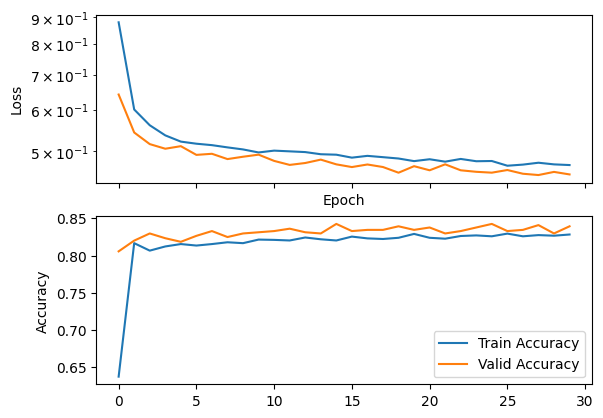

In [11]:
plot_losses(train_losses, valid_losses, train_accuracys, validate_accuracys)

# HPO

In [29]:
import optuna
num_epochs = 10
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, dataset_train, dataset_val, num_epochs), n_trials=30)




[I 2024-06-10 16:51:14,575] A new study created in memory with name: no-name-432c630d-9ce7-47bf-98b6-1804df1f3a6d


Epoch: 1/10, Train Loss: 0.9911, Valid Loss: 0.9696, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 41.68 sec
Epoch: 2/10, Train Loss: 0.9466, Valid Loss: 0.9637, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 42.30 sec
Epoch: 3/10, Train Loss: 0.9423, Valid Loss: 0.9620, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 41.55 sec
Epoch: 4/10, Train Loss: 0.9409, Valid Loss: 0.9618, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 41.32 sec
Epoch: 5/10, Train Loss: 0.9401, Valid Loss: 0.9613, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 41.48 sec
Epoch: 6/10, Train Loss: 0.9397, Valid Loss: 0.9609, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 39.26 sec
Epoch: 7/10, Train Loss: 0.9390, Valid Loss: 0.9608, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 38.94 sec
Epoch: 8/10, Train Loss: 0.9386, Valid Loss: 0.9608, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 39.01 sec
Epoch: 9/10, Train Loss: 0.9384, Valid Loss: 0.9609, Train Accuracy: 1.0, Valid 

[I 2024-06-10 16:57:57,993] Trial 0 finished with value: 0.9608807717098662 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.3999299806504355, 'filters_layer0': 50, 'filter_size_layer0': 5, 'stride_layer0': 1, 'padding_layer0': 2, 'filters_layer1': 60, 'filter_size_layer1': 7, 'stride_layer1': 1, 'padding_layer1': 2, 'filters_layer2': 25, 'filter_size_layer2': 6, 'stride_layer2': 1, 'padding_layer2': 3, 'dense_layer0': 106, 'dense_layer1': 87, 'dense_layer2': 63, 'adam_learning_rate': 0.0017882696824408188}. Best is trial 0 with value: 0.9608807717098662.


Epoch: 10/10, Train Loss: 0.9382, Valid Loss: 0.9609, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 38.88 sec
Epoch: 1/10, Train Loss: 0.5518, Valid Loss: 0.4182, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 25.54 sec
Epoch: 2/10, Train Loss: 0.3971, Valid Loss: 0.3914, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 25.28 sec
Epoch: 3/10, Train Loss: 0.3662, Valid Loss: 0.4423, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 25.21 sec
Epoch: 4/10, Train Loss: 0.3391, Valid Loss: 0.4149, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 25.12 sec
Epoch: 5/10, Train Loss: 0.3198, Valid Loss: 0.4542, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 25.29 sec
Epoch: 6/10, Train Loss: 0.3092, Valid Loss: 0.4153, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 24.95 sec
Epoch: 7/10, Train Loss: 0.3039, Valid Loss: 0.3565, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 25.10 sec
Epoch: 8/10, Train Loss: 0.2568, Valid Loss: 0.3172, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:02:09,564] Trial 1 finished with value: 0.27099792782424326 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.31094456253392155, 'filters_layer0': 30, 'filter_size_layer0': 5, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 57, 'filter_size_layer1': 4, 'stride_layer1': 1, 'padding_layer1': 2, 'filters_layer2': 21, 'filter_size_layer2': 6, 'stride_layer2': 1, 'padding_layer2': 3, 'dense_layer0': 41, 'dense_layer1': 48, 'dense_layer2': 59, 'adam_learning_rate': 4.711210871206942e-05}. Best is trial 1 with value: 0.27099792782424326.


Epoch: 10/10, Train Loss: 0.1906, Valid Loss: 0.2710, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 25.03 sec
Epoch: 1/10, Train Loss: 0.6032, Valid Loss: 0.3961, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 24.49 sec
Epoch: 2/10, Train Loss: 0.3298, Valid Loss: 0.3755, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 24.46 sec
Epoch: 3/10, Train Loss: 0.2592, Valid Loss: 0.3658, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 23.93 sec
Epoch: 4/10, Train Loss: 0.2118, Valid Loss: 0.2896, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 24.08 sec
Epoch: 5/10, Train Loss: 0.1791, Valid Loss: 0.2896, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 24.03 sec
Epoch: 6/10, Train Loss: 0.2050, Valid Loss: 0.2645, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 24.15 sec
Epoch: 7/10, Train Loss: 0.1284, Valid Loss: 0.2595, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 24.05 sec
Epoch: 8/10, Train Loss: 0.1130, Valid Loss: 0.2935, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:06:10,857] Trial 2 finished with value: 0.26752053555249083 and parameters: {'N_conv_layers': 1, 'N_dense_layers': 3, 'dropout_rate': 0.24951561117437754, 'filters_layer0': 16, 'filter_size_layer0': 4, 'stride_layer0': 1, 'padding_layer0': 3, 'dense_layer0': 109, 'dense_layer1': 29, 'dense_layer2': 123, 'adam_learning_rate': 0.00035418813358637695}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 0.0843, Valid Loss: 0.2675, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 23.94 sec
Epoch: 1/10, Train Loss: 0.9383, Valid Loss: 0.9016, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.27 sec
Epoch: 2/10, Train Loss: 0.8323, Valid Loss: 0.8234, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 12.20 sec
Epoch: 3/10, Train Loss: 0.7666, Valid Loss: 0.8010, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 11.79 sec
Epoch: 4/10, Train Loss: 0.7313, Valid Loss: 0.7818, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 12.01 sec
Epoch: 5/10, Train Loss: 0.7120, Valid Loss: 0.7656, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.24 sec
Epoch: 6/10, Train Loss: 0.7061, Valid Loss: 0.7634, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.48 sec
Epoch: 7/10, Train Loss: 0.6941, Valid Loss: 0.7472, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.65 sec
Epoch: 8/10, Train Loss: 0.6875, Valid Loss: 0.7672, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:08:27,093] Trial 3 finished with value: 0.6855377538165943 and parameters: {'N_conv_layers': 1, 'N_dense_layers': 1, 'dropout_rate': 0.4936386377552212, 'filters_layer0': 52, 'filter_size_layer0': 6, 'stride_layer0': 3, 'padding_layer0': 2, 'dense_layer0': 25, 'adam_learning_rate': 0.00033680180853251635}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 0.5680, Valid Loss: 0.6855, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.52 sec
Epoch: 1/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.75 sec
Epoch: 2/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.26 sec
Epoch: 3/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.45 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.19 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.33 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.37 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.52 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:11:39,965] Trial 4 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 2, 'N_dense_layers': 3, 'dropout_rate': 0.1408390266597383, 'filters_layer0': 48, 'filter_size_layer0': 5, 'stride_layer0': 3, 'padding_layer0': 1, 'filters_layer1': 57, 'filter_size_layer1': 7, 'stride_layer1': 2, 'padding_layer1': 2, 'dense_layer0': 17, 'dense_layer1': 57, 'dense_layer2': 43, 'adam_learning_rate': 0.0005220817794896793}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 18.69 sec
Epoch: 1/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.00 sec
Epoch: 2/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.74 sec
Epoch: 3/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.75 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.75 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.45 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.50 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.71 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:14:06,786] Trial 5 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 1, 'N_dense_layers': 2, 'dropout_rate': 0.07871222268874223, 'filters_layer0': 53, 'filter_size_layer0': 6, 'stride_layer0': 3, 'padding_layer0': 2, 'dense_layer0': 16, 'dense_layer1': 114, 'adam_learning_rate': 7.645454414017538e-05}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.71 sec
Epoch: 1/10, Train Loss: 0.8849, Valid Loss: 0.6453, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.83 sec
Epoch: 2/10, Train Loss: 0.5415, Valid Loss: 0.5055, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.30 sec
Epoch: 3/10, Train Loss: 0.4660, Valid Loss: 0.4674, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.49 sec
Epoch: 4/10, Train Loss: 0.4290, Valid Loss: 0.4516, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.32 sec
Epoch: 5/10, Train Loss: 0.4090, Valid Loss: 0.4381, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.30 sec
Epoch: 6/10, Train Loss: 0.3978, Valid Loss: 0.4343, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.41 sec
Epoch: 7/10, Train Loss: 0.3872, Valid Loss: 0.4212, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.21 sec
Epoch: 8/10, Train Loss: 0.3801, Valid Loss: 0.4160, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:16:50,233] Trial 6 finished with value: 0.40207897961351957 and parameters: {'N_conv_layers': 1, 'N_dense_layers': 3, 'dropout_rate': 0.19734008299672728, 'filters_layer0': 46, 'filter_size_layer0': 4, 'stride_layer0': 3, 'padding_layer0': 1, 'dense_layer0': 117, 'dense_layer1': 126, 'dense_layer2': 123, 'adam_learning_rate': 1.8733243751021864e-05}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 0.3641, Valid Loss: 0.4021, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.30 sec
Epoch: 1/10, Train Loss: 1.0725, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.50 sec
Epoch: 2/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 18.37 sec
Epoch: 3/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 18.82 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.00 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 18.37 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.55 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 18.78 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:19:59,101] Trial 7 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 2, 'dropout_rate': 0.4772190816353226, 'filters_layer0': 49, 'filter_size_layer0': 5, 'stride_layer0': 2, 'padding_layer0': 3, 'filters_layer1': 60, 'filter_size_layer1': 7, 'stride_layer1': 2, 'padding_layer1': 1, 'filters_layer2': 35, 'filter_size_layer2': 3, 'stride_layer2': 2, 'padding_layer2': 1, 'dense_layer0': 45, 'dense_layer1': 66, 'adam_learning_rate': 0.0013196362292351058}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 18.97 sec
Epoch: 1/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.52 sec
Epoch: 2/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.24 sec
Epoch: 3/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.19 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.06 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.04 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.11 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.01 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:22:30,710] Trial 8 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 2, 'N_dense_layers': 1, 'dropout_rate': 0.20900634711584914, 'filters_layer0': 21, 'filter_size_layer0': 5, 'stride_layer0': 3, 'padding_layer0': 3, 'filters_layer1': 38, 'filter_size_layer1': 5, 'stride_layer1': 1, 'padding_layer1': 2, 'dense_layer0': 95, 'adam_learning_rate': 3.1725449069002554e-07}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.33 sec
Epoch: 1/10, Train Loss: 1.0990, Valid Loss: 1.0975, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.16 sec
Epoch: 2/10, Train Loss: 1.0983, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.40 sec
Epoch: 3/10, Train Loss: 1.0984, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.58 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.21 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.84 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.27 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.77 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:25:11,619] Trial 9 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 1, 'dropout_rate': 0.16147752071647348, 'filters_layer0': 43, 'filter_size_layer0': 7, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 52, 'filter_size_layer1': 3, 'stride_layer1': 1, 'padding_layer1': 3, 'filters_layer2': 36, 'filter_size_layer2': 7, 'stride_layer2': 3, 'padding_layer2': 1, 'dense_layer0': 37, 'adam_learning_rate': 2.4020364706111696e-05}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.73 sec
Epoch: 1/10, Train Loss: 0.6483, Valid Loss: 0.5610, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.78 sec
Epoch: 2/10, Train Loss: 0.5284, Valid Loss: 0.5368, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.20 sec
Epoch: 3/10, Train Loss: 0.5129, Valid Loss: 0.5256, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.63 sec
Epoch: 4/10, Train Loss: 0.5044, Valid Loss: 0.5160, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.34 sec
Epoch: 5/10, Train Loss: 0.4986, Valid Loss: 0.5095, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.54 sec
Epoch: 6/10, Train Loss: 0.4943, Valid Loss: 0.5052, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.49 sec
Epoch: 7/10, Train Loss: 0.4911, Valid Loss: 0.4956, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.79 sec
Epoch: 8/10, Train Loss: 0.4884, Valid Loss: 0.4923, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:27:28,105] Trial 10 finished with value: 0.4869643356719039 and parameters: {'N_conv_layers': 1, 'N_dense_layers': 2, 'dropout_rate': 0.30798646657979944, 'filters_layer0': 9, 'filter_size_layer0': 3, 'stride_layer0': 2, 'padding_layer0': 3, 'dense_layer0': 78, 'dense_layer1': 8, 'adam_learning_rate': 0.01611024465381059}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 0.4843, Valid Loss: 0.4870, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.27 sec
Epoch: 1/10, Train Loss: 1.0499, Valid Loss: 1.0413, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.03 sec
Epoch: 2/10, Train Loss: 1.0255, Valid Loss: 1.0185, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.23 sec
Epoch: 3/10, Train Loss: 1.0014, Valid Loss: 0.9923, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 18.91 sec
Epoch: 4/10, Train Loss: 0.9751, Valid Loss: 0.9642, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 18.93 sec
Epoch: 5/10, Train Loss: 0.9483, Valid Loss: 0.9385, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.57 sec
Epoch: 6/10, Train Loss: 0.9212, Valid Loss: 0.9110, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.02 sec
Epoch: 7/10, Train Loss: 0.8907, Valid Loss: 0.8791, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.18 sec
Epoch: 8/10, Train Loss: 0.8543, Valid Loss: 0.8403, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:30:40,087] Trial 11 finished with value: 0.7511925217523621 and parameters: {'N_conv_layers': 2, 'N_dense_layers': 3, 'dropout_rate': 0.31567993505956676, 'filters_layer0': 26, 'filter_size_layer0': 3, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 10, 'filter_size_layer1': 3, 'stride_layer1': 3, 'padding_layer1': 1, 'dense_layer0': 62, 'dense_layer1': 26, 'dense_layer2': 120, 'adam_learning_rate': 2.2006332235492167e-06}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 0.7651, Valid Loss: 0.7512, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.20 sec
Epoch: 1/10, Train Loss: 1.3256, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.68 sec
Epoch: 2/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.32 sec
Epoch: 3/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.53 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.45 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.95 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.27 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.27 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:34:02,716] Trial 12 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.2995302452994059, 'filters_layer0': 28, 'filter_size_layer0': 4, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 39, 'filter_size_layer1': 5, 'stride_layer1': 3, 'padding_layer1': 3, 'filters_layer2': 9, 'filter_size_layer2': 4, 'stride_layer2': 1, 'padding_layer2': 3, 'dense_layer0': 68, 'dense_layer1': 40, 'dense_layer2': 14, 'adam_learning_rate': 0.04222556709698781}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.73 sec
Epoch: 1/10, Train Loss: 1.0663, Valid Loss: 1.0621, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.57 sec
Epoch: 2/10, Train Loss: 1.0463, Valid Loss: 1.0419, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.35 sec
Epoch: 3/10, Train Loss: 1.0161, Valid Loss: 1.0024, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.52 sec
Epoch: 4/10, Train Loss: 0.9717, Valid Loss: 0.9638, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.29 sec
Epoch: 5/10, Train Loss: 0.9396, Valid Loss: 0.9427, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.30 sec
Epoch: 6/10, Train Loss: 0.9211, Valid Loss: 0.9282, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.54 sec
Epoch: 7/10, Train Loss: 0.9089, Valid Loss: 0.9198, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.45 sec
Epoch: 8/10, Train Loss: 0.9003, Valid Loss: 0.9131, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:37:17,081] Trial 13 finished with value: 0.9028636451995966 and parameters: {'N_conv_layers': 2, 'N_dense_layers': 3, 'dropout_rate': 0.3838555642418755, 'filters_layer0': 12, 'filter_size_layer0': 4, 'stride_layer0': 2, 'padding_layer0': 2, 'filters_layer1': 20, 'filter_size_layer1': 4, 'stride_layer1': 1, 'padding_layer1': 3, 'dense_layer0': 124, 'dense_layer1': 40, 'dense_layer2': 88, 'adam_learning_rate': 3.7149469240647783e-06}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 0.8856, Valid Loss: 0.9029, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.30 sec
Epoch: 1/10, Train Loss: 1.0989, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.87 sec
Epoch: 2/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.42 sec
Epoch: 3/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.68 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.60 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.51 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.57 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.41 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:40:32,652] Trial 14 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 2, 'N_dense_layers': 2, 'dropout_rate': 0.013345029758136007, 'filters_layer0': 63, 'filter_size_layer0': 6, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 46, 'filter_size_layer1': 4, 'stride_layer1': 2, 'padding_layer1': 1, 'dense_layer0': 85, 'dense_layer1': 17, 'adam_learning_rate': 0.008151660223489744}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.53 sec
Epoch: 1/10, Train Loss: 0.9322, Valid Loss: 0.8745, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 38.64 sec
Epoch: 2/10, Train Loss: 0.8273, Valid Loss: 0.8283, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 38.46 sec
Epoch: 3/10, Train Loss: 0.7840, Valid Loss: 0.8160, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 38.52 sec
Epoch: 4/10, Train Loss: 0.7044, Valid Loss: 0.7135, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 38.42 sec
Epoch: 5/10, Train Loss: 0.6370, Valid Loss: 0.7086, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 38.36 sec
Epoch: 6/10, Train Loss: 0.6141, Valid Loss: 0.6943, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 38.46 sec
Epoch: 7/10, Train Loss: 0.5934, Valid Loss: 0.7131, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 38.53 sec
Epoch: 8/10, Train Loss: 0.5807, Valid Loss: 0.7246, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:46:58,707] Trial 15 finished with value: 0.7069214112044245 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.25633495321133903, 'filters_layer0': 18, 'filter_size_layer0': 4, 'stride_layer0': 1, 'padding_layer0': 2, 'filters_layer1': 33, 'filter_size_layer1': 6, 'stride_layer1': 1, 'padding_layer1': 2, 'filters_layer2': 64, 'filter_size_layer2': 5, 'stride_layer2': 1, 'padding_layer2': 3, 'dense_layer0': 52, 'dense_layer1': 45, 'dense_layer2': 83, 'adam_learning_rate': 0.00010198584859240814}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 0.5652, Valid Loss: 0.7069, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 39.57 sec
Epoch: 1/10, Train Loss: 1.0801, Valid Loss: 1.0830, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.27 sec
Epoch: 2/10, Train Loss: 1.0788, Valid Loss: 1.0823, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 15.28 sec
Epoch: 3/10, Train Loss: 1.0775, Valid Loss: 1.0813, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 16.92 sec
Epoch: 4/10, Train Loss: 1.0764, Valid Loss: 1.0802, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.01 sec
Epoch: 5/10, Train Loss: 1.0754, Valid Loss: 1.0799, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.98 sec
Epoch: 6/10, Train Loss: 1.0747, Valid Loss: 1.0796, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.79 sec
Epoch: 7/10, Train Loss: 1.0738, Valid Loss: 1.0787, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 14.02 sec
Epoch: 8/10, Train Loss: 1.0731, Valid Loss: 1.0782, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:49:24,847] Trial 16 finished with value: 1.0781165584323877 and parameters: {'N_conv_layers': 1, 'N_dense_layers': 2, 'dropout_rate': 0.37538345462494405, 'filters_layer0': 35, 'filter_size_layer0': 3, 'stride_layer0': 2, 'padding_layer0': 3, 'dense_layer0': 33, 'dense_layer1': 74, 'adam_learning_rate': 1.1507646664251044e-07}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 1.0720, Valid Loss: 1.0781, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 13.82 sec
Epoch: 1/10, Train Loss: 1.0571, Valid Loss: 0.9956, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.62 sec
Epoch: 2/10, Train Loss: 0.9117, Valid Loss: 0.8384, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.80 sec
Epoch: 3/10, Train Loss: 0.7910, Valid Loss: 0.7615, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.70 sec
Epoch: 4/10, Train Loss: 0.7368, Valid Loss: 0.7257, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.06 sec
Epoch: 5/10, Train Loss: 0.7075, Valid Loss: 0.7034, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.83 sec
Epoch: 6/10, Train Loss: 0.6891, Valid Loss: 0.6884, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.64 sec
Epoch: 7/10, Train Loss: 0.6771, Valid Loss: 0.6773, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.83 sec
Epoch: 8/10, Train Loss: 0.6679, Valid Loss: 0.6714, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:52:42,717] Trial 17 finished with value: 0.6606769179611394 and parameters: {'N_conv_layers': 2, 'N_dense_layers': 3, 'dropout_rate': 0.25272883287286313, 'filters_layer0': 32, 'filter_size_layer0': 7, 'stride_layer0': 1, 'padding_layer0': 1, 'filters_layer1': 27, 'filter_size_layer1': 4, 'stride_layer1': 2, 'padding_layer1': 3, 'dense_layer0': 102, 'dense_layer1': 28, 'dense_layer2': 47, 'adam_learning_rate': 3.4357653796555778e-06}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 0.6544, Valid Loss: 0.6607, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.67 sec
Epoch: 1/10, Train Loss: 0.9630, Valid Loss: 0.9638, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 17.06 sec
Epoch: 2/10, Train Loss: 0.9417, Valid Loss: 0.9626, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 17.22 sec
Epoch: 3/10, Train Loss: 0.9405, Valid Loss: 0.9621, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 17.31 sec
Epoch: 4/10, Train Loss: 0.9401, Valid Loss: 0.9621, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 17.23 sec
Epoch: 5/10, Train Loss: 0.9398, Valid Loss: 0.9617, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 18.10 sec
Epoch: 6/10, Train Loss: 0.9394, Valid Loss: 0.9615, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 17.79 sec
Epoch: 7/10, Train Loss: 0.9391, Valid Loss: 0.9615, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 17.32 sec
Epoch: 8/10, Train Loss: 0.9387, Valid Loss: 0.9612, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:55:36,852] Trial 18 finished with value: 0.9610476174524852 and parameters: {'N_conv_layers': 2, 'N_dense_layers': 2, 'dropout_rate': 0.34395373256266804, 'filters_layer0': 19, 'filter_size_layer0': 4, 'stride_layer0': 2, 'padding_layer0': 2, 'filters_layer1': 47, 'filter_size_layer1': 6, 'stride_layer1': 3, 'padding_layer1': 1, 'dense_layer0': 56, 'dense_layer1': 86, 'adam_learning_rate': 0.004124684424915245}. Best is trial 2 with value: 0.26752053555249083.


Epoch: 10/10, Train Loss: 0.9377, Valid Loss: 0.9610, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 17.03 sec
Epoch: 1/10, Train Loss: 0.6819, Valid Loss: 0.4863, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.79 sec
Epoch: 2/10, Train Loss: 0.4067, Valid Loss: 0.3545, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.76 sec
Epoch: 3/10, Train Loss: 0.3149, Valid Loss: 0.2982, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.28 sec
Epoch: 4/10, Train Loss: 0.2700, Valid Loss: 0.2680, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.63 sec
Epoch: 5/10, Train Loss: 0.2306, Valid Loss: 0.2482, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.30 sec
Epoch: 6/10, Train Loss: 0.2156, Valid Loss: 0.2341, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.60 sec
Epoch: 7/10, Train Loss: 0.1948, Valid Loss: 0.2175, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.00 sec
Epoch: 8/10, Train Loss: 0.1687, Valid Loss: 0.1918, Train Accuracy: 1.0, Valid

[I 2024-06-10 17:58:53,248] Trial 19 finished with value: 0.2169726493408221 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.4274955946547482, 'filters_layer0': 41, 'filter_size_layer0': 6, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 49, 'filter_size_layer1': 3, 'stride_layer1': 1, 'padding_layer1': 2, 'filters_layer2': 9, 'filter_size_layer2': 7, 'stride_layer2': 2, 'padding_layer2': 2, 'dense_layer0': 84, 'dense_layer1': 55, 'dense_layer2': 99, 'adam_learning_rate': 0.00011811448485959384}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 0.1508, Valid Loss: 0.2170, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.42 sec
Epoch: 1/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 31.05 sec
Epoch: 2/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.79 sec
Epoch: 3/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.70 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.73 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.72 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.63 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.70 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 18:04:00,731] Trial 20 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 1, 'N_dense_layers': 2, 'dropout_rate': 0.44217543338543047, 'filters_layer0': 40, 'filter_size_layer0': 6, 'stride_layer0': 1, 'padding_layer0': 2, 'dense_layer0': 84, 'dense_layer1': 97, 'adam_learning_rate': 0.00026904609977300496}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.63 sec
Epoch: 1/10, Train Loss: 0.7735, Valid Loss: 0.5449, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.22 sec
Epoch: 2/10, Train Loss: 0.5071, Valid Loss: 0.4606, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.97 sec
Epoch: 3/10, Train Loss: 0.4356, Valid Loss: 0.4221, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.68 sec
Epoch: 4/10, Train Loss: 0.4002, Valid Loss: 0.4166, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.56 sec
Epoch: 5/10, Train Loss: 0.3815, Valid Loss: 0.3833, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.55 sec
Epoch: 6/10, Train Loss: 0.3741, Valid Loss: 0.3908, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.82 sec
Epoch: 7/10, Train Loss: 0.3575, Valid Loss: 0.3827, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.18 sec
Epoch: 8/10, Train Loss: 0.3539, Valid Loss: 0.3879, Train Accuracy: 1.0, Valid

[I 2024-06-10 18:07:18,285] Trial 21 finished with value: 0.3676612381042276 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.4271198204942821, 'filters_layer0': 38, 'filter_size_layer0': 6, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 49, 'filter_size_layer1': 3, 'stride_layer1': 1, 'padding_layer1': 2, 'filters_layer2': 8, 'filter_size_layer2': 7, 'stride_layer2': 2, 'padding_layer2': 2, 'dense_layer0': 112, 'dense_layer1': 54, 'dense_layer2': 109, 'adam_learning_rate': 2.2949922197300647e-05}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 0.3380, Valid Loss: 0.3677, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.18 sec
Epoch: 1/10, Train Loss: 0.7527, Valid Loss: 0.4751, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.09 sec
Epoch: 2/10, Train Loss: 0.4531, Valid Loss: 0.4393, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.35 sec
Epoch: 3/10, Train Loss: 0.4100, Valid Loss: 0.4134, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.03 sec
Epoch: 4/10, Train Loss: 0.3836, Valid Loss: 0.4274, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.21 sec
Epoch: 5/10, Train Loss: 0.3524, Valid Loss: 0.3816, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.89 sec
Epoch: 6/10, Train Loss: 0.3352, Valid Loss: 0.3792, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 22.11 sec
Epoch: 7/10, Train Loss: 0.3254, Valid Loss: 0.4011, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.53 sec
Epoch: 8/10, Train Loss: 0.3073, Valid Loss: 0.4134, Train Accuracy: 1.0, Valid

[I 2024-06-10 18:10:37,861] Trial 22 finished with value: 0.32681009042972586 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.2732067556469327, 'filters_layer0': 28, 'filter_size_layer0': 5, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 64, 'filter_size_layer1': 4, 'stride_layer1': 1, 'padding_layer1': 2, 'filters_layer2': 19, 'filter_size_layer2': 6, 'stride_layer2': 3, 'padding_layer2': 2, 'dense_layer0': 94, 'dense_layer1': 33, 'dense_layer2': 99, 'adam_learning_rate': 0.00012052210578143784}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 0.2847, Valid Loss: 0.3268, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 19.96 sec
Epoch: 1/10, Train Loss: 0.9589, Valid Loss: 0.7893, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.66 sec
Epoch: 2/10, Train Loss: 0.6522, Valid Loss: 0.5986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.56 sec
Epoch: 3/10, Train Loss: 0.5582, Valid Loss: 0.5365, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.57 sec
Epoch: 4/10, Train Loss: 0.5085, Valid Loss: 0.4844, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.45 sec
Epoch: 5/10, Train Loss: 0.4786, Valid Loss: 0.4780, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.22 sec
Epoch: 6/10, Train Loss: 0.4596, Valid Loss: 0.4621, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.49 sec
Epoch: 7/10, Train Loss: 0.4510, Valid Loss: 0.4716, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.75 sec
Epoch: 8/10, Train Loss: 0.4360, Valid Loss: 0.4496, Train Accuracy: 1.0, Valid

[I 2024-06-10 18:14:03,781] Trial 23 finished with value: 0.4372802546530376 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.3515968577599985, 'filters_layer0': 23, 'filter_size_layer0': 7, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 53, 'filter_size_layer1': 3, 'stride_layer1': 2, 'padding_layer1': 2, 'filters_layer2': 21, 'filter_size_layer2': 6, 'stride_layer2': 2, 'padding_layer2': 2, 'dense_layer0': 76, 'dense_layer1': 54, 'dense_layer2': 69, 'adam_learning_rate': 9.452032952467327e-06}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 0.4202, Valid Loss: 0.4373, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.82 sec
Epoch: 1/10, Train Loss: 1.0030, Valid Loss: 0.9835, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.73 sec
Epoch: 2/10, Train Loss: 0.9577, Valid Loss: 0.9683, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.69 sec
Epoch: 3/10, Train Loss: 0.9468, Valid Loss: 0.9633, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.67 sec
Epoch: 4/10, Train Loss: 0.9428, Valid Loss: 0.9615, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.55 sec
Epoch: 5/10, Train Loss: 0.9410, Valid Loss: 0.9609, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.15 sec
Epoch: 6/10, Train Loss: 0.9400, Valid Loss: 0.9605, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.48 sec
Epoch: 7/10, Train Loss: 0.9394, Valid Loss: 0.9603, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.37 sec
Epoch: 8/10, Train Loss: 0.9390, Valid Loss: 0.9603, Train Accuracy: 1.0, Valid

[I 2024-06-10 18:19:08,996] Trial 24 finished with value: 0.9604115514847096 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.21058478919757184, 'filters_layer0': 14, 'filter_size_layer0': 4, 'stride_layer0': 2, 'padding_layer0': 3, 'filters_layer1': 43, 'filter_size_layer1': 4, 'stride_layer1': 1, 'padding_layer1': 3, 'filters_layer2': 53, 'filter_size_layer2': 7, 'stride_layer2': 1, 'padding_layer2': 2, 'dense_layer0': 128, 'dense_layer1': 67, 'dense_layer2': 107, 'adam_learning_rate': 0.0008815047659962179}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 0.9385, Valid Loss: 0.9604, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 30.82 sec
Epoch: 1/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 29.51 sec
Epoch: 2/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 29.64 sec
Epoch: 3/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 29.51 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 29.48 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 29.51 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 29.38 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 29.52 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 18:24:04,175] Trial 25 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 2, 'N_dense_layers': 3, 'dropout_rate': 0.4433076420025495, 'filters_layer0': 32, 'filter_size_layer0': 6, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 55, 'filter_size_layer1': 5, 'stride_layer1': 1, 'padding_layer1': 1, 'dense_layer0': 44, 'dense_layer1': 18, 'dense_layer2': 128, 'adam_learning_rate': 6.766435390167018e-05}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 29.59 sec
Epoch: 1/10, Train Loss: 1.0993, Valid Loss: 1.0987, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.84 sec
Epoch: 2/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 21.11 sec
Epoch: 3/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 21.20 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.81 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.20 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.17 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.64 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 18:27:30,976] Trial 26 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.13388759160790534, 'filters_layer0': 57, 'filter_size_layer0': 5, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 33, 'filter_size_layer1': 3, 'stride_layer1': 2, 'padding_layer1': 2, 'filters_layer2': 16, 'filter_size_layer2': 5, 'stride_layer2': 2, 'padding_layer2': 3, 'dense_layer0': 96, 'dense_layer1': 44, 'dense_layer2': 67, 'adam_learning_rate': 1.1445435052547665e-06}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.36 sec
Epoch: 1/10, Train Loss: 0.5518, Valid Loss: 0.4487, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.69 sec
Epoch: 2/10, Train Loss: 0.4111, Valid Loss: 0.4255, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.65 sec
Epoch: 3/10, Train Loss: 0.3665, Valid Loss: 0.3970, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 21.00 sec
Epoch: 4/10, Train Loss: 0.3349, Valid Loss: 0.3645, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 21.00 sec
Epoch: 5/10, Train Loss: 0.3046, Valid Loss: 0.3353, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.65 sec
Epoch: 6/10, Train Loss: 0.2909, Valid Loss: 0.3245, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.65 sec
Epoch: 7/10, Train Loss: 0.2758, Valid Loss: 0.3481, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.79 sec
Epoch: 8/10, Train Loss: 0.2564, Valid Loss: 0.3268, Train Accuracy: 1.0, Valid

[I 2024-06-10 18:30:58,733] Trial 27 finished with value: 0.2994371126238285 and parameters: {'N_conv_layers': 2, 'N_dense_layers': 2, 'dropout_rate': 0.3396216567941902, 'filters_layer0': 34, 'filter_size_layer0': 5, 'stride_layer0': 2, 'padding_layer0': 2, 'filters_layer1': 63, 'filter_size_layer1': 4, 'stride_layer1': 1, 'padding_layer1': 2, 'dense_layer0': 67, 'dense_layer1': 58, 'adam_learning_rate': 0.00019801216259610446}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 0.2423, Valid Loss: 0.2994, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.57 sec
Epoch: 1/10, Train Loss: 0.6568, Valid Loss: 0.4712, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 21.07 sec
Epoch: 2/10, Train Loss: 0.4608, Valid Loss: 0.4511, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 21.07 sec
Epoch: 3/10, Train Loss: 0.4314, Valid Loss: 0.4212, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 21.22 sec
Epoch: 4/10, Train Loss: 0.4088, Valid Loss: 0.4194, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.83 sec
Epoch: 5/10, Train Loss: 0.3912, Valid Loss: 0.4234, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.29 sec
Epoch: 6/10, Train Loss: 0.3823, Valid Loss: 0.3992, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.93 sec
Epoch: 7/10, Train Loss: 0.3651, Valid Loss: 0.4042, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 20.71 sec
Epoch: 8/10, Train Loss: 0.3546, Valid Loss: 0.3885, Train Accuracy: 1.0, Valid

[I 2024-06-10 18:34:27,792] Trial 28 finished with value: 0.4041253427480769 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.2835918356903765, 'filters_layer0': 41, 'filter_size_layer0': 5, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 42, 'filter_size_layer1': 6, 'stride_layer1': 2, 'padding_layer1': 3, 'filters_layer2': 29, 'filter_size_layer2': 6, 'stride_layer2': 3, 'padding_layer2': 1, 'dense_layer0': 116, 'dense_layer1': 77, 'dense_layer2': 91, 'adam_learning_rate': 4.2076497462924025e-05}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 0.3300, Valid Loss: 0.4041, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 21.15 sec
Epoch: 1/10, Train Loss: 1.0987, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 49.57 sec
Epoch: 2/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 49.48 sec
Epoch: 3/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 49.52 sec
Epoch: 4/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 49.56 sec
Epoch: 5/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 49.49 sec
Epoch: 6/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 49.55 sec
Epoch: 7/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 49.62 sec
Epoch: 8/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid

[I 2024-06-10 18:42:43,480] Trial 29 finished with value: 1.0986123085021973 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.41398885803815366, 'filters_layer0': 15, 'filter_size_layer0': 4, 'stride_layer0': 1, 'padding_layer0': 3, 'filters_layer1': 50, 'filter_size_layer1': 5, 'stride_layer1': 1, 'padding_layer1': 2, 'filters_layer2': 46, 'filter_size_layer2': 7, 'stride_layer2': 1, 'padding_layer2': 2, 'dense_layer0': 106, 'dense_layer1': 31, 'dense_layer2': 44, 'adam_learning_rate': 0.002553522293912029}. Best is trial 19 with value: 0.2169726493408221.


Epoch: 10/10, Train Loss: 1.0986, Valid Loss: 1.0986, Train Accuracy: 1.0, Valid Accuracy: 1.0, Duration: 49.54 sec


In [35]:

best_perams = study.best_params
print(type(best_perams))
save = False
if save:
    with open('best_perams.pkl', 'wb') as f:
        pickle.dump(best_perams, f)

    with open('best_perams.pkl', 'rb') as f:
        best_perams = pickle.load(f)



<class 'dict'>


# Train best model

In [28]:
with open('best_perams.pkl', 'rb') as f:
    best_perams = pickle.load(f)
best_model = create_torch_model_CNN_dict(best_perams)

torch.manual_seed(42)
num_epochs = 100

#print(peram_to_optimize)
peram_to_optimize = best_model.peram_to_optimize
learning_rate = best_perams['adam_learning_rate']*0.5

optimizer = optim.Adam(peram_to_optimize, lr=learning_rate)
best_model.train()

train_losses, valid_losses, train_accuracys, validate_accuracys = train_model(best_model, num_epochs, dataset_train, dataset_val, optimizer, loss_function)

Epoch: 1/100, Train Loss: 0.7713, Valid Loss: 0.5152, Train Accuracy: 0.7014865279197693, Valid Accuracy: 0.8282504081726074, Duration: 25.48 sec
Epoch: 2/100, Train Loss: 0.4089, Valid Loss: 0.4711, Train Accuracy: 0.8625954389572144, Valid Accuracy: 0.8459069132804871, Duration: 24.57 sec
Epoch: 3/100, Train Loss: 0.3415, Valid Loss: 0.3869, Train Accuracy: 0.8754519820213318, Valid Accuracy: 0.8539325594902039, Duration: 23.43 sec
Epoch: 4/100, Train Loss: 0.3031, Valid Loss: 0.3495, Train Accuracy: 0.8887103199958801, Valid Accuracy: 0.869983971118927, Duration: 24.23 sec
Epoch: 5/100, Train Loss: 0.2655, Valid Loss: 0.3279, Train Accuracy: 0.8963439464569092, Valid Accuracy: 0.869983971118927, Duration: 22.88 sec
Epoch: 6/100, Train Loss: 0.2416, Valid Loss: 0.2968, Train Accuracy: 0.9043793082237244, Valid Accuracy: 0.8940609693527222, Duration: 22.76 sec
Epoch: 7/100, Train Loss: 0.2234, Valid Loss: 0.3027, Train Accuracy: 0.9104058146476746, Valid Accuracy: 0.8812199234962463, 

# Save Model

In [38]:
"""
save = True
if save:
    # Function to save the model
    model_name = 'CNN_HPO_6_11'
    def save_model(model, CNN_path="CNN.pth"):
        torch.save(model, CNN_path)
        print("Model saved to {}".format(CNN_path))
    enc = 'training_results/' + model_name + '/CNN.pth'
    
    save_model(best_model, CNN_path=enc)
    np.savetxt('training_results/' + model_name + '/train_loss.txt', diz_loss['train_loss'])
    np.savetxt('training_results/' + model_name + '/val_loss.txt', diz_loss['val_loss'])
"""
torch.save(best_model, 'CNN_HPO_6_11.pth')


#model_scripted = torch.jit.script(best_model) # Export to TorchScript
#model_scripted.save('model_scripted.pt') # Save

AttributeError: Can't pickle local object 'create_torch_model_CNN_dict.<locals>.torch_CNN_HPO'

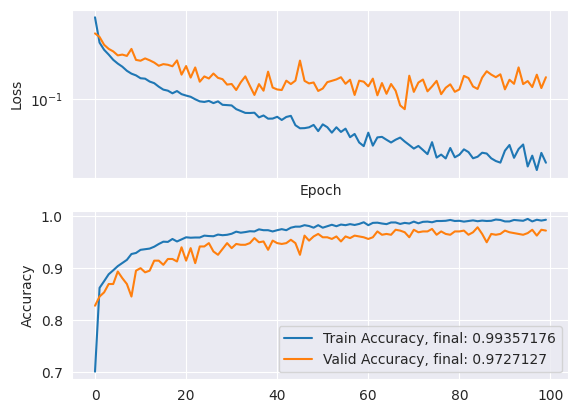

In [31]:
plot_losses(train_losses, valid_losses, train_accuracys, validate_accuracys)

# Run model

In [ ]:
def test_func(model, dataset):
    output = np.zeros(len(dataset))
    label = np.zeros(len(dataset))
    for batch in dataset:
        model(batch)
        
for i in range(10):
    test_func(model, dataset_train)

/home/sk0rt3/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
print()

# CPU test

# Train model

In [ ]:
model = create_torch_model_CNN(3).to(device)
model = model.to(device)


dataset_train = train_loader.dataset[0]
dataset_val = valid_loader.dataset[0]


dataset_train = dataset_train.to(device)
dataset_val = dataset_val.to(device)

learning_rate = 0.001
torch.manual_seed(42)
peram_to_optimize = model.parameters()



optimizer = optim.Adam(peram_to_optimize, lr=learning_rate)

model = model.to(device)

model.train()

num_epochs = 10



print(next(model.parameters()).device, dataset_train.is_cuda)


train_losses, valid_losses = train_model(model, num_epochs, dataset_train, dataset_val, optimizer, loss_function)

plot_losses(train_losses, valid_losses)


cpu False
torch.cuda.ByteTensor torch.FloatTensor


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)